### Библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import re
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import defaultdict

#### Подгружаем данные

In [2]:
url_train="https://drive.google.com/u/0/uc?id=1RhXDaw02wlVtvUggA9C81i78vDTM8u14&export=download"
train = pd.read_csv(url_train) # мой подfuelTypeготовленный датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#### сначало тест

In [3]:
#оставляем 'mileage'
test.drop(['modelDate', 
            'vehicleConfiguration',
            'description',
            'Комплектация',
            'ПТС',
            'Таможня', 
            'Владение', 
            'id','Руль'], inplace = True, axis = 1)

#Создадим словарь типов машин, чтобы использовать метод map
dict_bodyType= {'седан': 1,
'внедорожник': 2,
'хэтчбек': 3,
'минивэн': 4,
'универсал': 5,
'фургон': 6,
'купе': 7,
'пикап': 8,
'микроавтобус' : 9,
'кабриолет' : 10,
'лифтбек' : 11,
'родстер' : 12,
'кабриолет' : 13}

test.loc[(test["bodyType"] == "седан 2 дв.") , 'bodyType'] = "седан"
test.loc[(test["bodyType"] == "внедорожник 5 дв.") , 'bodyType'] = "внедорожник"
test.loc[(test["bodyType"] == "хэтчбек 5 дв.") , 'bodyType'] = "хэтчбек"
test.loc[(test["bodyType"] == "универсал 5 дв.") , 'bodyType'] = "универсал"
test.loc[(test["bodyType"] == "компактвэн") , 'bodyType'] = "микроавтобус"
test.loc[(test["bodyType"] == "хэтчбек 3 дв.") , 'bodyType'] = "хэтчбек"
#Заменяем
test.bodyType = test.bodyType.astype(np.str)
#Заменяем
test['bodyType'] = test['bodyType'].map(dict_bodyType)


#колонка Name

test['name'] = test['name'].apply(lambda x: str(str(x).split()[0]))
test.loc[(test["name"] == "520d") , 'name'] = "5 серия"
test.loc[(test["name"] == "318d") , 'name'] = "7 серия"
test.loc[(test["name"] == "550i") , 'name'] = "5 серия"
test.loc[(test["name"] == "M50d") , 'name'] = "X5"
test.loc[(test["name"] == "28i") , 'name'] = "X3"
test.loc[(test["name"] == "20d") , 'name'] = "X3"
test.loc[(test["name"] == "30d") , 'name'] = "X3"
test.loc[(test["name"] == "520i") , 'name'] = "5 серия"
test.loc[(test["name"] == "328i") , 'name'] = "3 серия"
test.loc[(test["name"] == "116i") , 'name'] = "1 серия"
test.loc[(test["name"] == "35d") , 'name'] = "X5"
test.loc[(test["name"] == "730d") , 'name'] = "7 серия"
test.loc[(test["name"] == "20i") , 'name'] = "X3"
test.loc[(test["name"] == "530d") , 'name'] = "5 серия"
test.loc[(test["name"] == "528i") , 'name'] = "5 серия"
test.loc[(test["name"] == "35i") , 'name'] = "X5"
test.loc[(test["name"] == "xDrive20d") , 'name'] = "X3"
test.loc[(test["name"] == "540i") , 'name'] = "5 серия"
test.loc[(test["name"] == "520d") , 'name'] = "5 серия"
test.loc[(test["name"] == "48i") , 'name'] = "X5"
test.loc[(test["name"] == "135i") , 'name'] = "1 серия"
test.loc[(test["name"] == "2.2") , 'name'] = "3 серия"
test.loc[(test["name"] == "335xi") , 'name'] = "3 серия"
test.loc[(test["name"] == "745i") , 'name'] = "7 серия"
test.loc[(test["name"] == "320d") , 'name'] = "3 серия"
test.loc[(test["name"] == "530xi") , 'name'] = "5 серия"
test.loc[(test["name"] == "530i") , 'name'] = "5 серия"
test.loc[(test["name"] == "528i") , 'name'] = "5 серия"
test.loc[(test["name"] == "320d") , 'name'] = "3 серия"
test.loc[(test["name"] == "320i") , 'name'] = "3 серия"
test.loc[(test["name"] == "550i") , 'name'] = "5 серия"
test.loc[(test["name"] == "520d") , 'name'] = "5 серия"
test.loc[(test["name"] == "318d") , 'name'] = "3 серия"
test.loc[(test["name"] == "550i") , 'name'] = "5 серия"
test.loc[(test["name"] == "M50d") , 'name'] = "X5"
test.loc[(test["name"] == "520d") , 'name'] = "5 серия"
test.loc[(test["name"] == "318d") , 'name'] = "3 серия"
test.loc[(test["name"] == "550i") , 'name'] = "5 серия"
test.loc[(test["name"] == "530i") , 'name'] = "5 серия"
test.loc[(test["name"] == "528i") , 'name'] = "5 серия"
test.loc[(test["name"] == "320d") , 'name'] = "3 серия"
test.loc[(test["name"] == "335i") , 'name'] = "3 серия"
test.loc[(test["name"] == "25i") , 'name'] = "X1"
test.loc[(test["name"] == "316i") , 'name'] = "3 серия"
test.loc[(test["name"] == "3.0d") , 'name'] = "X5"
test.loc[(test["name"] == "730Ld") , 'name'] = "7 серия"
test.loc[(test["name"] == "3.0i") , 'name'] = "X5"
test.loc[(test["name"] == "325i") , 'name'] = "3 серия"
test.loc[(test["name"] == "30i") , 'name'] = "X3"
test.loc[(test["name"] == "118i") , 'name'] = "1 серия"
test.loc[(test["name"] == "40i") , 'name'] = "X5"
test.loc[(test["name"] == "M760Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "3.0si") , 'name'] = "X5"
test.loc[(test["name"] == "4.4") , 'name'] = "M6"
test.loc[(test["name"] == "40d") , 'name'] = "X5"
test.loc[(test["name"] == "4.8i") , 'name'] = "X5"
test.loc[(test["name"] == "535d") , 'name'] = "5 серия"
test.loc[(test["name"] == "420i") , 'name'] = "4 серия Gran Coupe"
test.loc[(test["name"] == "525i") , 'name'] = "5 серия"
test.loc[(test["name"] == "750i") , 'name'] = "7 серия"
test.loc[(test["name"] == "120i") , 'name'] = "1 серия"
test.loc[(test["name"] == "330i") , 'name'] = "3 серия"
test.loc[(test["name"] == "120d") , 'name'] = "1 серия"
test.loc[(test["name"] == "318i") , 'name'] = "3 серия"
test.loc[(test["name"] == "725Ld") , 'name'] = "7 серия"
test.loc[(test["name"] == "760Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "840d") , 'name'] = "8 серия"
test.loc[(test["name"] == "420d") , 'name'] = "4 серия"
test.loc[(test["name"] == "M85from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.ensemble import RandomForestRegressor

RANDOM_SEED = 42
forest = RandomForestRegressor(n_estimators=30, max_features=10,  max_depth = 20, random_state=RANDOM_SEED) #max_depth = 15, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100, verbose = 100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred1 = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape:.2f} ')

print_regression_metrics(y_test, y_pred)0i") , 'name'] = "8 серия"
test.loc[(test["name"] == "523i") , 'name'] = "5 серия"
test.loc[(test["name"] == "18d") , 'name'] = "X1"
test.loc[(test["name"] == "650i") , 'name'] = "6 серия Gran Coupe"
test.loc[(test["name"] == "18i") , 'name'] = "X1"
test.loc[(test["name"] == "750Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "4.4i") , 'name'] = "X5"
test.loc[(test["name"] == "630d") , 'name'] = "6 серия GT"
test.loc[(test["name"] == "645i") , 'name'] = "6 серия"
test.loc[(test["name"] == "3.0") , 'name'] = "3 серия"
test.loc[(test["name"] == "25d") , 'name'] = "X5"
test.loc[(test["name"] == "535i") , 'name'] = "5 серия"
test.loc[(test["name"] == "640i") , 'name'] = "6 серия Gran Coupe"
test.loc[(test["name"] == "320d") , 'name'] = "3 серия"
test.loc[(test["name"] == "xDrive20i") , 'name'] = "X2"
test.loc[(test["name"] == "525xi") , 'name'] = "5 серия"
test.loc[(test["name"] == "735i") , 'name'] = "7 серия"
test.loc[(test["name"] == "50i") , 'name'] = "X5"
test.loc[(test["name"] == "740Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "M550d") , 'name'] = "5 серия"
test.loc[(test["name"] == "630i") , 'name'] = "6 серия GT"
test.loc[(test["name"] == "520Li") , 'name'] = "5 серия"
test.loc[(test["name"] == "4.0") , 'name'] = "4 серия"
test.loc[(test["name"] == "520Li") , 'name'] = "5 серия"
test.loc[(test["name"] == "730Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "740d") , 'name'] = "7 серия"
test.loc[(test["name"] == "325xi") , 'name'] = "3 серия"
test.loc[(test["name"] == "518") , 'name'] = "5 серия"
test.loc[(test["name"] == "M235i") , 'name'] = "2 серия Grand Tourer"
test.loc[(test["name"] == "220i") , 'name'] = "2 серия"
test.loc[(test["name"] == "740i") , 'name'] = "7 серия"
test.loc[(test["name"] == "Competition") , 'name'] = "M5"
test.loc[(test["name"] == "M50i") , 'name'] = "X6"
test.loc[(test["name"] == "428i") , 'name'] = "4 серия"
test.loc[(test["name"] == "1.5") , 'name'] = "3 серия"
test.loc[(test["name"] == "750Ld") , 'name'] = "7 серия"
test.loc[(test["name"] == "M40d") , 'name'] = "X4"
test.loc[(test["name"] == "730i") , 'name'] = "7 серия"
test.loc[(test["name"] == "CS") , 'name'] = "M4"
test.loc[(test["name"] == "525xd") , 'name'] = "5 серия"
test.loc[(test["name"] == "M40i") , 'name'] = "X3"
test.loc[(test["name"] == "1.5hyb") , 'name'] = "i8"
test.loc[(test["name"] == "325xi") , 'name'] = "3 серия"
test.loc[(test["name"] == "528Li") , 'name'] = "5 серия"
test.loc[(test["name"] == "640d") , 'name'] = "6 серия GT"
test.loc[(test["name"] == "3.0sd") , 'name'] = "X5"
test.loc[(test["name"] == "Electro") , 'name'] = "i3"
test.loc[(test["name"] == "530Li") , 'name'] = "5 серия"
test.loc[(test["name"] == "740Ld") , 'name'] = "7 серия"
test.loc[(test["name"] == "330xi") , 'name'] = "3 серия"
test.loc[(test["name"] == "M340i") , 'name'] = "3 серия"
test.loc[(test["name"] == "M550i") , 'name'] = "5 серия"
test.loc[(test["name"] == "750d") , 'name'] = "7 серия"
test.loc[(test["name"] == "35is") , 'name'] = "Z4"
test.loc[(test["name"] == "760i") , 'name'] = "7 серия"
test.loc[(test["name"] == "125i") , 'name'] = "1 серия"
test.loc[(test["name"] == "130i") , 'name'] = "1 серия"
test.loc[(test["name"] == "218i") , 'name'] = "2 серия Active Tourer"
test.loc[(test["name"] == "5.0") , 'name'] = "X5 M"
test.loc[(test["name"] == "xDrive18d") , 'name'] = "X2"
test.loc[(test["name"] == "728i") , 'name'] = "7 серия"
test.loc[(test["name"] == "620d") , 'name'] = "6 серия GT"
test.loc[(test["name"] == "sDrive18i") , 'name'] = "X1"
test.loc[(test["name"] == "4.8is") , 'name'] = "X5"
test.loc[(test["name"] == "330d") , 'name'] = "3 серия"
test.loc[(test["name"] == "430i") , 'name'] = "4 серия"
test.loc[(test["name"] == "735Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "4.6is") , 'name'] = "X5"
test.loc[(test["name"] == "323i") , 'name'] = "3 серия"
test.loc[(test["name"] == "M135i") , 'name'] = "1 серия"
test.loc[(test["name"] == "340i") , 'name'] = "3 серия GT"
test.loc[(test["name"] == "118d") , 'name'] = "1 серия"
test.loc[(test["name"] == "ActiveHybrid") , 'name'] = "7 серия GT"
test.loc[(test["name"] == "23d") , 'name'] = "X1"
test.loc[(test["name"] == "2.0") , 'name'] = "3 серия"
test.loc[(test["name"] == "23i") , 'name'] = "Z4"
test.loc[(test["name"] == "545i") , 'name'] = "5 серия"
test.loc[(test["name"] == "530xd") , 'name'] = "5 серия"
test.loc[(test["name"] == "440i") , 'name'] = "4 серия"
test.loc[(test["name"] == "745Li") , 'name'] = "7 серия"
test.loc[(test["name"] == "316") , 'name'] = "3 серия"
test.loc[(test["name"] == "Active") , 'name'] = "2 серия Active Tourer"
test.loc[(test["name"] == "525d") , 'name'] = "5 серия"
test.loc[(test["name"] == "330xd") , 'name'] = "3 серия"


#Чистим от л.с.
test['enginePower'] = test['enginePower'].apply(lambda x: float(str(x).split()[0]))



test.dropna(subset = ['engineDisplacement'],inplace = True)
test.loc[(test["engineDisplacement"] == "6.0+") , 'engineDisplacement'] = "7.0"
test.loc[(test["engineDisplacement"] == "undefined LTR") , 'engineDisplacement'] = "3.0"
test['engineDisplacement']=test['engineDisplacement'].apply(lambda x: str(str(x).split()[0]))


test[test.numberOfDoors.isna()]
test.dropna(subset = ['numberOfDoors'],inplace = True)

test.numberOfDoors = test.numberOfDoors.astype(np.int32)

test['Владельцы']=test['Владельцы'].apply(lambda x: int(str(x).split()[0]))
test['Владельцы'].astype(np.int)


#переводим engineDisplacement из obj в float
test.engineDisplacement = test.engineDisplacement.astype(np.float)



#Переводим в int productionDate и mileage, enginePower, Владельцы 
test.productionDate = test.productionDate.astype(np.int64)
test.mileage = test.mileage.astype(np.int64)
test.enginePower = test.enginePower.astype(np.int32)
test['Владельцы'] = test['Владельцы'].astype(np.int32)

test.loc[(test["Состояние"] == "Не требует ремонта") , 'Состояние'] = "Не битый"




### теперь Train

In [4]:
train.drop(['autoCatalogUrl', 'status', 'closingReason','canonicalUrl','avitoId','Аудиосистема','Фары', 'description','Руль','typeOfTrade'], inplace = True, axis = 1)

train.dropna(subset = ['bodyType'],inplace = True)

#Создадим словарь типов машин, чтобы использовать метод map
dict_bodyType= {'седан': 1,
'внедорожник': 2,
'хэтчбек': 3,
'минивэн': 4,
'универсал': 5,
'фургон': 6,
'купе': 7,
'пикап': 8,
'микроавтобус' : 9,
'кабриолет' : 10}

#Заменяем
train['bodyType'] = train['bodyType'].map(dict_bodyType)


#Чистим от л.с.
train['enginePower'] = train['enginePower'].apply(lambda x: float(str(x).split()[0]))

train.dropna(subset = ['engineDisplacement'],inplace = True)

train.loc[(train["engineDisplacement"] == "6.0+") , 'engineDisplacement'] = "7.0"

train.enginePower = train.enginePower.astype(np.int32)

#Коробка передач 
train.loc[(train["vehicleTransmission"] == "робот") , 'vehicleTransmission'] = "роботизированная"

train[train.numberOfDoors.isna()]
train.dropna(subset = ['numberOfDoors'],inplace = True)

train.numberOfDoors = train.numberOfDoors.astype(np.int32)

train.loc[(train["Владельцы"] == "4+") , 'Владельцы'] = 4

train.Владельцы = train.Владельцы.astype(np.int32)


#Дропаем оставшиеся признаки

train.drop(['Электростеклоподъемники', 'Усилитель руля', 'Климат-контроль','Салон','Диски','marketPrice'], inplace = True, axis = 1)



#переводим engineDisplacement из obj в float
train.engineDisplacement = train.engineDisplacement.astype(np.float)


#Переводим в нижний регистр Color и fuelType

train.color = train.color.apply(lambda x: x.lower())
train.fuelType = train.fuelType.apply(lambda x: x.lower())

#меняем в Color серебряный и золотой
train.loc[(train["color"] == "серебряный") , 'color'] = 'серебристый'
train.loc[(train["color"] == "золотой") , 'color'] = 'золотистый'


### Заново LabelEncoding по всем остальным признакам

In [5]:
encoder = LabelEncoder()

#name

names1 =train.name.values.tolist() 
names2 = test.name.values.tolist()

names = list(set(names1 + names2))

encoder.fit(names)
train.name = encoder.transform(train.name)
test.name = encoder.transform(test.name)


##color

colors1 =train.color.values.tolist() 
colors2 = test.color.values.tolist()

colors = list(set(colors1 + colors2))

encoder.fit(colors)
train.color = encoder.transform(train.color)
test.color = encoder.transform(test.color)

##vehicleTransmission

transmissions1 =train.vehicleTransmission.values.tolist() 
transmissions2 = test.vehicleTransmission.values.tolist()

transmissions = list(set(transmissions1 + transmissions2))

encoder.fit(transmissions)
train.vehicleTransmission = encoder.transform(train.vehicleTransmission)
test.vehicleTransmission = encoder.transform(test.vehicleTransmission)

## Привод

privods1 =train['Привод'].values.tolist()
privods2 = test['Привод'].values.tolist()

privods = list(set(privods1 + privods2))

encoder.fit(privods)
train['Привод'] = encoder.transform(train['Привод'])
test['Привод'] = encoder.transform(test['Привод'])

## Состояние

conditions1 =train['Состояние'].values.tolist()
conditions2 = test['Состояние'].values.tolist()

conditions = list(set(conditions1 + conditions2))

encoder.fit(conditions)
train['Состояние'] = encoder.transform(train['Состояние'])
test['Состояние'] = encoder.transform(test['Состояние'])

## fuelType

fueltypes1 =train['fuelType'].values.tolist()
fueltypes2 = test['fuelType'].values.tolist()

fueltypes = list(set(fueltypes1 + fueltypes2))

encoder.fit(fueltypes)
train['fuelType'] = encoder.transform(train['fuelType'])
test['fuelType'] = encoder.transform(test['fuelType'])


## brand

brands1 =train['brand'].values.tolist()
brands2 = test['brand'].values.tolist()

brands = list(set(brands1 + brands2))

encoder.fit(brands)
train['brand'] = encoder.transform(train['brand'])
test['brand'] = encoder.transform(test['brand'])




### добавляем в модель и в трейн два новых признака по примеру датасета Максима

In [6]:
#налоговые ставки

test['Налог']=test.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)
train['Налог']=train.enginePower.apply(lambda x: x*12 if x<=100 
                                           else x*25 if x>100 and x<=125
                                           else x*35 if x>125 and x<=150
                                           else x*45 if x>150 and x<=175
                                           else x*55 if x>175 and x<=200
                                           else x*65 if x>200 and x<=225
                                           else x*75 if x>225 and x<=250
                                           else x*150)

In [7]:
#Сколько лет автомобилю
test['Время эксплуатации'] = 2020 - test['productionDate']
train['Время эксплуатации'] = 2020 - train['productionDate']

In [8]:
# train.drop(['Налог','engineDisplacement', 'Время эксплуатации','Руль','Color_new','bodyType'], inplace = True, axis = 1)
# test.drop(['Налог','engineDisplacement', 'Время эксплуатации','Руль','Color_new','bodyType'], inplace = True, axis = 1)
train.drop(['engineDisplacement'], inplace = True, axis = 1)
test.drop(['engineDisplacement'], inplace = True, axis = 1)


### Модель

In [9]:
from sklearn.preprocessing import RobustScaler

X = train.drop(['itemPrice'], axis = 1)
y = train['itemPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)
# # нормализуем X_train
# transformer = RobustScaler()
# X_train = transformer.fit_transform(X_train)

# # normalising X_test
# transformer = RobustScaler()
# X_test = transformer.fit_transform(X_test)

# # normalising X_sub
# transformer = RobustScaler()
# X_sub = transformer.fit_transform(X_sub)

In [16]:
#Случайный лес
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import defaultdict

#n_estimators=30, max_features=15,  max_depth = 25
#n_estimators=10, max_features=12
#n_estimators=30, max_features=10,  max_depth = 20
RANDOM_SEED = 42
forest = RandomForestRegressor(n_estimators=30, max_features=10,  max_depth = 20, random_state=RANDOM_SEED) #max_depth = 15, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100, verbose = 100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred1 = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape:.2f} ')

print_regression_metrics(y_test, y_pred)

RMSE = 457905.98, MAE = 145048.23, R-sq = 0.76, MAPE = 0.32 


In [17]:
# Используем обученную модель для предсказания цены авто в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
#y_pred = forest.predict(X_test)

X_sub = test

predict_submission = forest.predict(X_sub)
predict_submission
sample_submission['price'] = predict_submission
sample_submission.price = sample_submission.price.astype(np.int32)
sample_submission.to_csv(f'submission_v.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1830155
1,1,2263733
2,2,1106479
3,3,2492549
4,4,5219466
5,5,1783477
6,6,1157719
7,7,806269
8,8,1474966
9,9,1849666


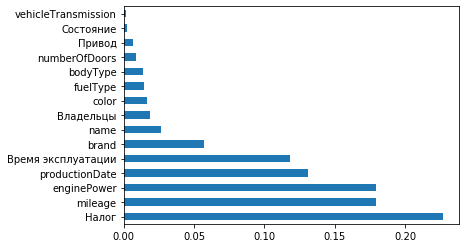

In [13]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')